In [48]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, ShuffleSplit, train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectPercentile, SelectFromModel
import pickle

In [2]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
main_df_Premium = pd.read_csv('../tabel/table from Datdota/tabel with rating teams PREMIUM.csv', index_col=0)
# удалить повторяющиеся матчи с Infamous, и сделать реиндекс 
main_df_Premium = main_df_Premium.drop(1).reset_index().drop('index', axis=1)

# удалть имена команд и сделать обучающие данные и ответы
X = main_df_Premium.loc[:, 'radiant_win':].drop(['radiant_name', 'dire_name', 'radiant_win'], axis=1)
y = main_df_Premium['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y = y.astype(int)

# заполнить пропуски на 0
X = X.fillna(0)

In [3]:
# Перекрестная проверка
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=5)
scores.mean()

0.67177046527510265

In [4]:
# применить  генератор разбиений перекрестной проверки (cross-validation splitter).
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cross_val_score(logreg, X, y, cv=kfold).mean()

0.66961404897709487

In [7]:
# перекрестная проверка со случайными перестанвокасми приразбиении
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, X, y, cv=shuffle_split)
scores.mean()

0.66187667560321706

In [8]:
# перекрестная проверка с использрвание групп
# разбиваем данные на обучающие+проверочные и тестовые
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0, test_size=0.15)
# арзбиваем на обучаюбщие и проверочые данные
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Размер обучающего набора: {} размер проверочного набора: {} размер тестового набора:" 
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Размер обучающего набора: 2376 размер проверочного набора: 793 размер тестового набора: 560



In [11]:
# деление на тестовые и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [81]:
# решетчатый поиск

param_grid = {'n_estimators': range(10,100, 10), 'max_depth': range(5, 50, 5),
              'max_features': range(5, 37, 3)}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(10, 100, 10), 'max_depth': range(5, 50, 5), 'max_features': range(5, 37, 3)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [82]:
print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидац. правильности:{:.2f}".format(grid_search.best_score_))

Правильность на тестовом наборе: 0.63
Наилучшие значения параметров: {'max_depth': 5, 'max_features': 17, 'n_estimators': 70}
Наилучшее значение кросс-валидац. правильности:0.67


In [93]:
# решетчатый посик на градиентном бустинге
param_grid = {'n_estimators': range(10,100, 10), 'max_depth': range(5, 50, 5),
              'max_features': range(5, 37, 3)}
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=3)

grid_search.fit(X_train,y_train)

print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидац. правильности:{:.2f}".format(grid_search.best_score_))

Правильность на тестовом наборе: 0.64
Наилучшие значения параметров: {'max_depth': 5, 'max_features': 23, 'n_estimators': 10}
Наилучшее значение кросс-валидац. правильности:0.67


In [12]:
best_GB = GradientBoostingClassifier(n_estimators=10, max_depth=5, max_features=5, random_state=10)
best_GB.fit(X_train, y_train)
best_GB.score(X_test, y_test)

0.63022508038585212

In [13]:
# предсказания
predict_GB = best_GB.predict(X_test)
# матрица ошибок
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predict_GB)
confusion

array([[255, 197],
       [148, 333]], dtype=int64)

In [14]:
# f1-мера
from sklearn.metrics import f1_score
f1_score(y_test, predict_GB)

0.65875370919881304

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_GB, target_names=['dire_win', 'radiant_win']))

             precision    recall  f1-score   support

   dire_win       0.63      0.56      0.60       452
radiant_win       0.63      0.69      0.66       481

avg / total       0.63      0.63      0.63       933



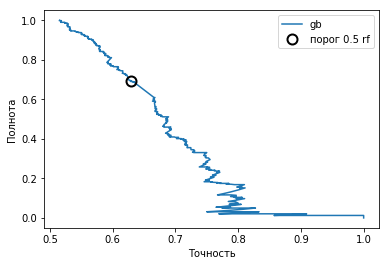

In [36]:
# в RandomForestClassifier есть predict_proba, но нет decision_function
precision_gb, recall_gb, thresholds_gb = metrics.precision_recall_curve(
y_test, best_GB.predict_proba(X_test)[:, 1])

plt.plot(precision_gb, recall_gb, label="gb")
close_default_gb = np.argmin(np.abs(thresholds_gb - 0.5))
plt.plot(precision_gb[close_default_gb], recall_gb[close_default_gb], 'o', c='k',
         markersize=10, label="порог 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.show()

In [93]:
y_pred_lower_threshold = best_GB.predict_proba(X_test)[:,1] > .4
print (classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       0.70      0.33      0.45       452
          1       0.58      0.86      0.69       481

avg / total       0.64      0.61      0.58       933



In [148]:
# save the model to disk
filename = 'GB_model.sav'
pickle.dump(best_GB, open(filename, 'wb'))

In [150]:
test_gb = pickle.load(open(filename, 'rb'))
test_gb.score(X_test, y_test)

0.63022508038585212

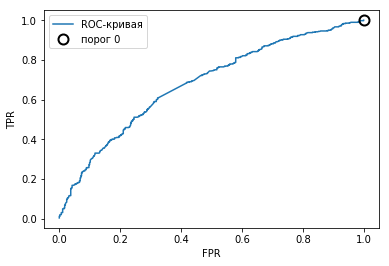

In [32]:
fpr, tpr, threshold = metrics.roc_curve(y_test, best_GB.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
# находим пороговое значение ближайшее к нулю
close_zero = np.argmin(np.abs(threshold))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='порог 0', fillstyle='none', c='k', mew=2)
plt.legend(loc='best')
plt.show()

In [33]:
gb_auc = metrics.roc_auc_score(y_test, best_GB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

AUC для градиентного бустинга - 0.681


# Оценка качества признаков

In [84]:
# используем f_classif (по умолчанию)
# и SelectPercentile, чтобы выбрать 50% признаков
select = SelectPercentile(percentile=18)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (2796, 36)
форма массива X_train_selected: (2796, 7)


In [85]:
mask = select.get_support()
print (mask)
# визуализируем булевы значения: черный - true, булый - false
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Индекс')

[ True False False False False  True False False False False  True False
 False False  True False False False False False False False False False
 False False False False  True False False False  True False  True False]


Text(0.5,0,'Индекс')

In [86]:
X_test_selected = select.transform(X_test)
print ('Правильность со всеми признаками: {:.3f}'.format(best_GB.score(X_test, y_test)))
best_GB_selected_70 = GradientBoostingClassifier(n_estimators=10, max_depth=5, max_features=5, random_state=10)
best_GB_selected_70.fit(X_train_selected, y_train)
print ('Правильность с 50% признаками: {:.3f}'.format(best_GB_selected_70.score(X_test_selected, y_test)))

Правильность со всеми признаками: 0.630
Правильность с 50% признаками: 0.641


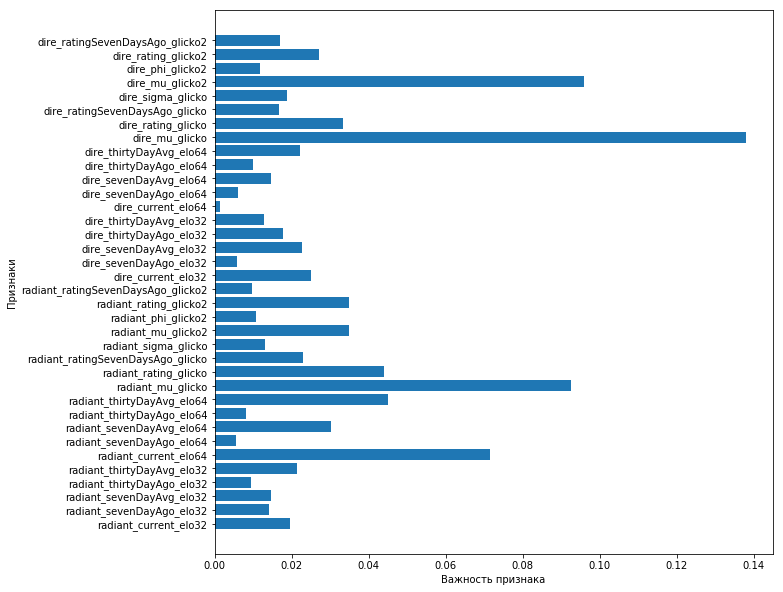

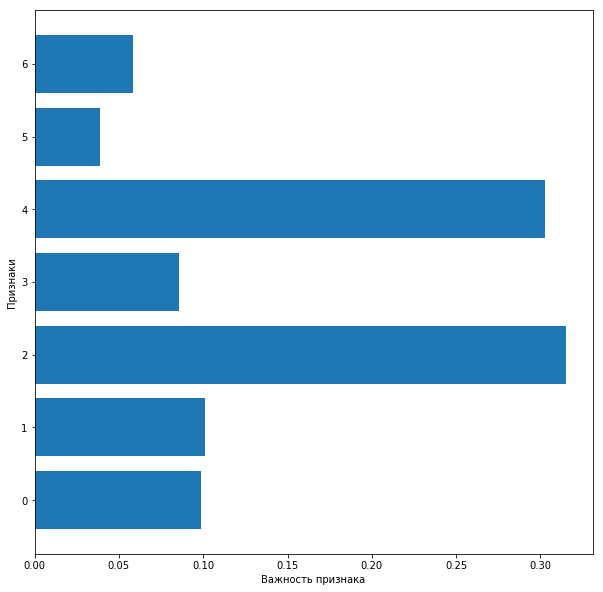

In [88]:
# важность признаков в бустинге

n_features = X_train.shape[1]
plt.figure(figsize=(10,10))
plt.barh(range(n_features), best_GB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.show()


n_features = X_train_selected.shape[1]
plt.figure(figsize=(10,10))
plt.barh(range(n_features), best_GB_selected_70.feature_importances_, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.show()
